# PDAL + Python


This notebook demonstrates how we can use PDAL as a Python library.


### Import all the things

In [1]:
import pdal

import numpy as np

import json
import pandas as pd
import scipy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### Set matplotlib to plot inline

In [2]:
%matplotlib inline

### Define a function to read a LAS/LAZ file and return a Pandas dataframe 

In [3]:
def pdal2df(pipelineJson,workingfile):
    """
    Feed me a LAS/LAZ file and a JSON pipeline, get back a Pandas dataframe with points in it.
    
    To inspect each element of this function and its outputs copy each line into its own notebook cell and run
    each in order. 
    """
    pipeline = pdal.Pipeline(json.dumps(pipelineJson))
    pipeline.validate() # check if our JSON and options were good
    pipeline.loglevel = 8 #really noisy
    count = pipeline.execute() # run the pipeline
    array = pipeline.arrays[0] # get data from the pipeline object
    
    description = array.dtype.descr # extract data descriptions from the array
    
    cols = [col for col, __ in description] # make a list of data column headers (PDAL dimension names)
    
    df = pd.DataFrame(array, columns=cols) # create a dataframe.
    
    return df

### Define a working file and a pipeline

We'll use a section of Dublin city lidar in this exercise. Our first pipeline reads in the LAZ file, and uses [`filters.mortonorder`](https://pdal.io/stages/filters.mortonorder.html) in reverse order to sort the points. We do this so that for any N points we plot, the points are spread widely over the region covered by data.

Later, we look at the effects of not sorting at all and using a normal-order morton filter. For now, let's read and look at some points.

In [4]:
workingfile = "../../sample_data/T_316000_235500.laz"


In [5]:
pipelineJson = [ workingfile,
    {
        "type":"filters.mortonorder",
        "reverse":"true"
    }
  ]

<div class="alert alert-info">
<strong>Do this in docker like:</strong>

<pre>
docker run -it -v /path/to/workingdir:/opt/data pdal/pdal \
                  pdal translate /opt/data/T_316000_235500.laz \
                  --filters.mortonorder.reverse=True \
                  --writers.las.filename=/opt/data/reversemorton.laz
</pre>

...and view the result using Cloudcompare (or other software)
</div>

### Create a dataframe and inspect it

You should see all the PDAL dimensions exposed as columns in the dataframe

In [6]:
%%time
df = pdal2df(pipelineJson, workingfile)

CPU times: user 7.98 s, sys: 585 ms, total: 8.57 s
Wall time: 8.86 s


In [7]:
df.head()

,X,Y,Z,Intensity,ReturnNumber,NumberOfReturns,ScanDirectionFlag,EdgeOfFlightLine,Classification,ScanAngleRank,UserData,PointSourceId,GpsTime
0,316030.431,235500.003,15.866,26,4,4,1,0,2,29.0,0,21,394503.605232
1,316030.357,235500.188,15.848,47,3,3,1,0,2,30.0,0,21,394503.605235
2,316030.192,235500.044,15.850,39,2,2,1,1,2,30.0,0,21,394503.614611
3,316301.870,235500.099,14.999,224,1,1,1,0,2,-5.0,0,21,394493.027207
4,316301.947,235500.098,14.990,295,1,1,1,0,2,11.0,0,22,394798.492154


In [8]:
#how many points have we got?
df.X.size

2952422

## Summary statistics

Since we've got our point data into Pandas, let's make some summary plots before we try to visualise any data. Let's start with 'whats the distribution of heights?'. And add some seaborn prettiness

In [9]:
import seaborn as sns

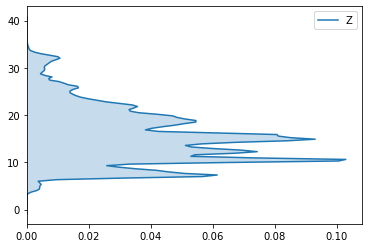

In [10]:
sns.kdeplot(df.Z, shade=True, vertical=True, clip=[0,40])

...now let's look at our distribution of point classes to see if any points are labelled:

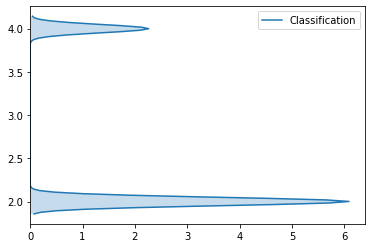

In [11]:
sns.kdeplot(df.Classification, shade=True, vertical=True)

We see a whole lot of `Classification` 2 - which is 'ground' in the ASPRS scheme of things. And a bit of 4 - or medium height vegetation. What about buildings? or noise? 

Now we need to see our data...

### Visualise some data

We can use `matplotlib`'s 3D axes to inspect our data in 3D. Because we used the reverse morton filter, we only need to plot a few thousand of our 2.9 million points to get a decent coverage of our data region. As a test, let's plot some points coloured by elevation - the `Z` dimension.

(316007.6907, 316502.7193, 235481.17335, 235895.35965)

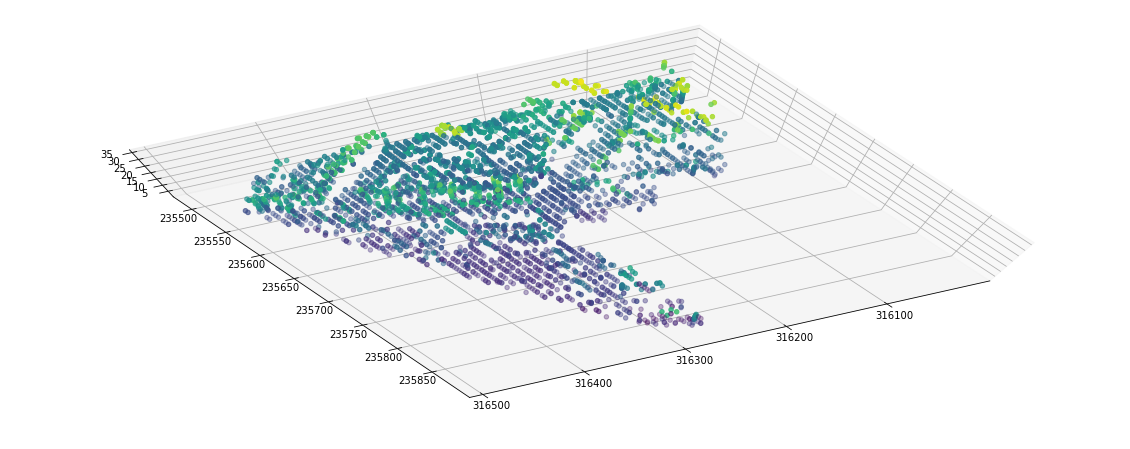

In [12]:
fig = plt.figure(figsize=(20,8))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(df.X[0:5000], df.Y[0:5000], df.Z[0:5000], c=df.Z[0:5000], cmap='viridis')
ax.view_init(80, 60)

ax.axis('tight')

### Making a more useful plot

OK that's hard to interpret. Try increasing the number of points and playing with colour scales to see if you can make more of it.

In terms of plotting to interrogate the data visually, height is useful but we know we want to check out something else. We can see from inspecting the data frame that maybe too many points are classified as ground.

So let's look. 

Before we do, let's make a helper function to allow us to repeatedly make plots. In the function below we're setting up a 3D and 2D axis, then filtering our dataframe to plot 'ground', 'non ground', and 'noise' points separately. In both axes we use a scatterplot to put points in space.

The function takes a dataframe, a dimension to use as a Z axis for plotting, and a number of points to display.

In [38]:
def plotthethings(dataframe, Zdim, npoints):
    """
    Input is a Pandas dataframe with PDAL dimensions as columns
    
    Output is a two panel plot with a 3D plot in the top panel and a 2D plot below
    
    On each axis we plot non ground (classifications except for two), ground (classification == 2),
    and noise (classification == 7) in that order. Yes we plot noise points twice, it's done that way to
    keep our where clauses as simple as we can.

    """
    fig = plt.figure(figsize=(20,20))

    ax = fig.add_subplot(211, projection='3d')

    ax.scatter(dataframe.X[0:npoints].where(dataframe.Classification[0:npoints] != 2),
           dataframe.Y[0:npoints].where(dataframe.Classification[0:npoints] != 2),
           Zdim[0:npoints].where(dataframe.Classification[0:npoints] != 2),
           c=dataframe.Intensity[0:npoints].where(dataframe.Classification[0:npoints] != 2), alpha=0.4, cmap='Blues_r')
    
    ax.scatter(dataframe.X[0:npoints].where(dataframe.Classification[0:npoints] == 2),
           dataframe.Y[0:npoints].where(dataframe.Classification[0:npoints] == 2),
           Zdim[0:npoints].where(dataframe.Classification[0:npoints] == 2),
           c=Zdim[0:npoints].where(dataframe.Classification[0:npoints] == 2), cmap='copper')
    
    ax.scatter(dataframe.X[0:npoints].where(dataframe.Classification[0:npoints] == 7),
           dataframe.Y[0:npoints].where(dataframe.Classification[0:npoints] == 7),
           Zdim[0:npoints].where(dataframe.Classification[0:npoints] == 7),
           c='red')

    ax.view_init(30,70)

    ax.legend(['not ground', 'ground', 'noise'])

    ax2 = fig.add_subplot(212)

    ax2.scatter(dataframe.X[0:npoints].where(dataframe.Classification[0:npoints] != 2),
            dataframe.Y[0:npoints].where(dataframe.Classification[0:npoints] != 2),
            c=Zdim[0:npoints].where(dataframe.Classification[0:npoints] != 2), cmap='Blues_r')
    ax2.scatter(dataframe.X[0:npoints].where(dataframe.Classification[0:npoints] == 2),
            dataframe.Y[0:npoints].where(dataframe.Classification[0:npoints] == 2),
            c=Zdim[0:npoints].where(dataframe.Classification[0:npoints] == 2),
            cmap='copper')
    ax2.scatter(dataframe.X[0:npoints].where(dataframe.Classification[0:npoints] == 7),
            dataframe.Y[0:npoints].where(dataframe.Classification[0:npoints] == 7),
            c='red')

    ax2.legend(['not ground', 'ground', 'noise'])

    ax.axis('tight')
    
    plt.show()
    

## Trying it out

Here's the test. Try adjusting the number of points - if you have a strong GPU plot all 2.9 million of them!

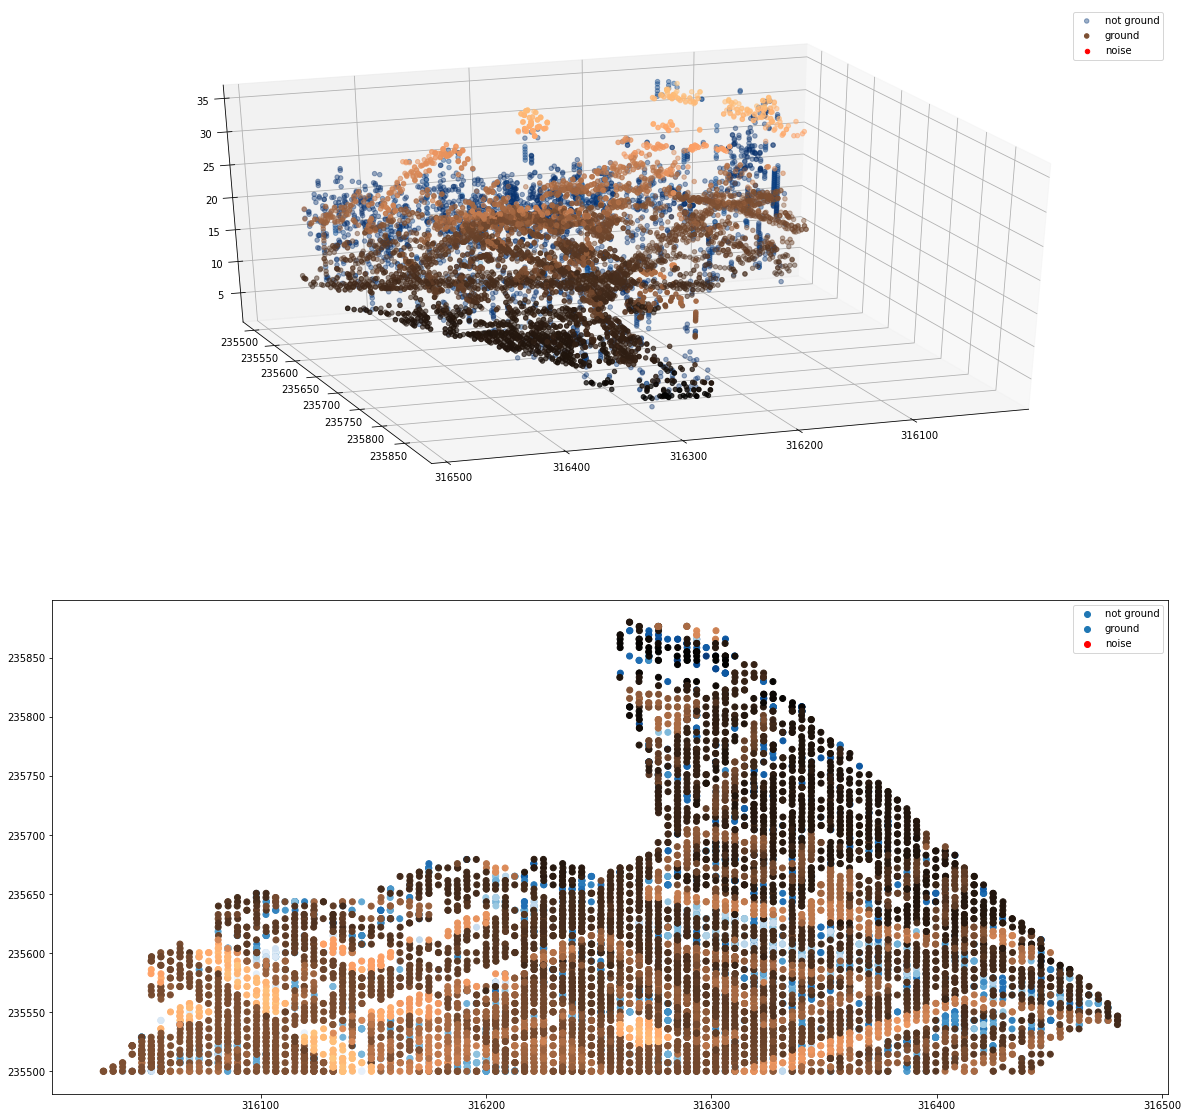

In [39]:
plotthethings(df, df.Z, 10000)

### Something's not right here...

There's not much else there than ground! Perhaps we can use our new friend PDAL to do better.

Gathering what we learned about in pipelines, we'll label all points as 'unclassified'; apply a local minimum filter then a progressive morphological filter to clean some noise, then label some points as 'ground'.

We're also adding the reverse morton filter, so we can visualise our region with fewer points in the plot.

In [15]:
pipelineJson2 = {
  "pipeline": [ workingfile,
    {
        "type":"filters.assign",
        "assignment":"Classification[:]=0"
    },
    {
        "type":"filters.elm"
    },
    {
        "type":"filters.pmf",
        "ignore":"Classification[7:7]"
    },
    {   "type":"filters.mortonorder",
        "reverse": True
    }
  ]
}

In [16]:
%%time

df2 = pdal2df(pipelineJson2, workingfile)

CPU times: user 11.8 s, sys: 685 ms, total: 12.5 s
Wall time: 12.6 s


### Visual inspection time

Using our plotting function, has our ratio of ground-to-everything changed?

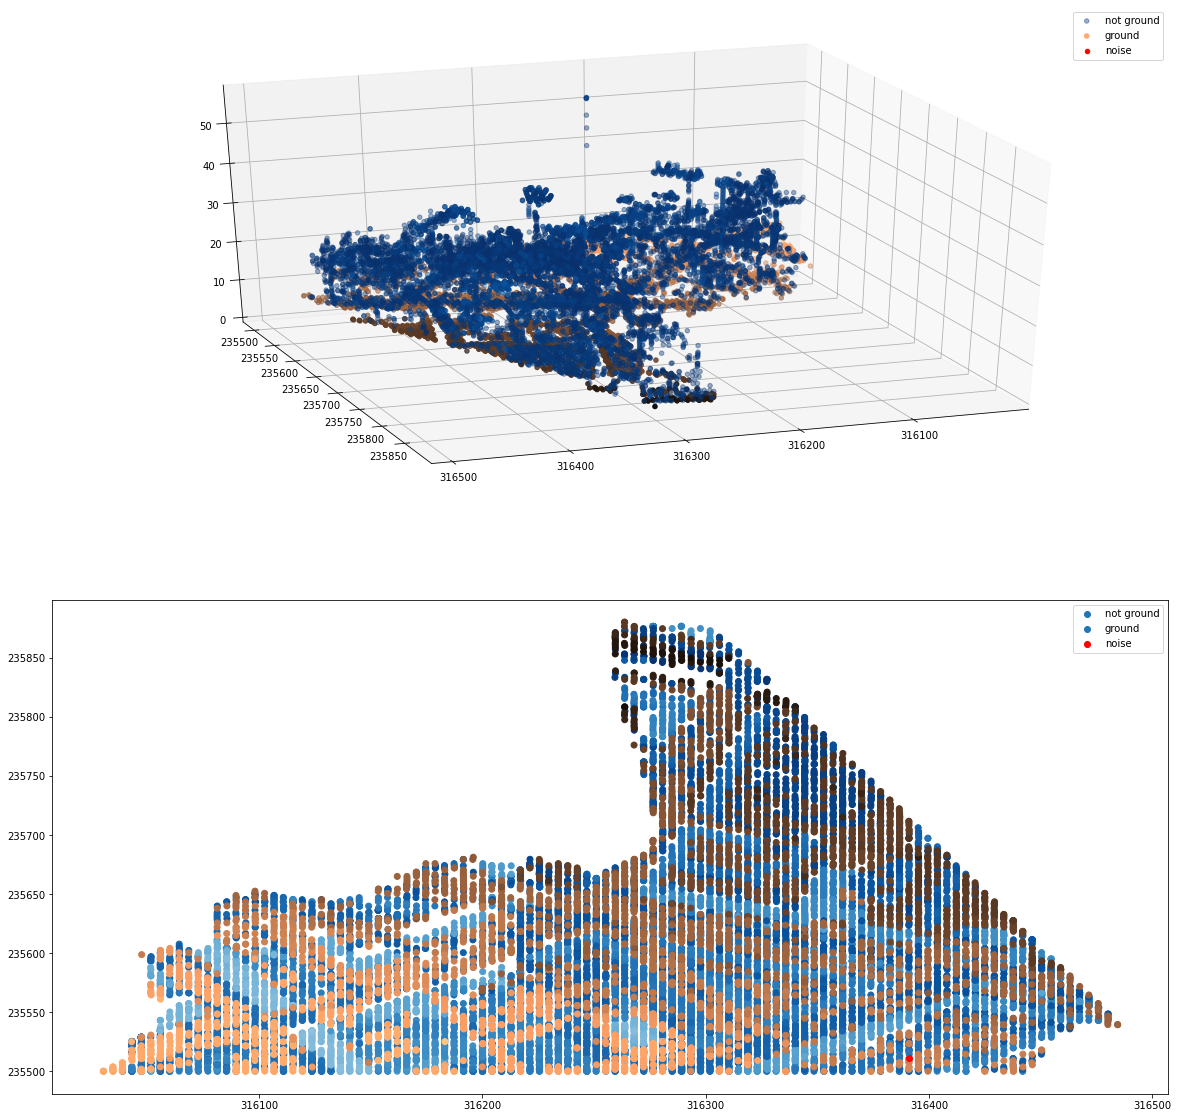

In [40]:
plotthethings(df2, df2.Z, 20000)

### That's better!

We're happier with ground classes now. We can see some buildings, and features that might be roads.

In the pipelines exercise of this workshop we used `filters.csf` to label ground points. As an exploration exercise try it out here if you have time. Do you see any differences between the PMF and CSF results?

<div class="alert alert-info">
<strong>Do this in docker like:</strong><br />

Save the pipeline JSON given above to:<pre>/path/to/workingdir/classifyground.json</pre>

Then run:

<pre>
docker run -it -v /path/to/workingdir:/opt/data pdal/ubuntu:1.8 \
                  pdal translate -i /opt/data/T_316000_235500.laz \
                  -o /opt/data/reversemorton-ground.laz \
                  --json /opt/data/classifyground.json  \
</pre>               

...and view the result using Cloudcompare (or other software)
</div>

### Next step - height above ground

Now we have ground, we can get some relative heights of things - using [`filters.hag_delaunay`](https://pdal.io/stages/filters.hag_delaunay), we'll create an extra dimension `HeightAboveGround` in our dataset, giving... heights above ground!

In this example height above ground (often 'normalised height') is computed by generating a delaunay triangulation using the 12 ground points nearest each non-ground point, and working out the difference in height between the mesh and the non-ground point. 

In [18]:
pipelineJson3 = [ workingfile,
    {
        "type":"filters.assign",
        "assignment":"Classification[:]=0"
    },
    {
        "type":"filters.elm",
        "cell":20.0,
        "class":7
    },
    {
        "type":"filters.pmf",
        "ignore":"Classification[7:7]"
    },
    {
        "type":"filters.outlier"
    },
    {
        "type":"filters.hag_delaunay"
    },
    {   "type":"filters.mortonorder",
        "reverse": True
    }
  ]

In [19]:
%%time

df3 = pdal2df(pipelineJson3, workingfile)

CPU times: user 1min 19s, sys: 1.36 s, total: 1min 20s
Wall time: 1min 21s


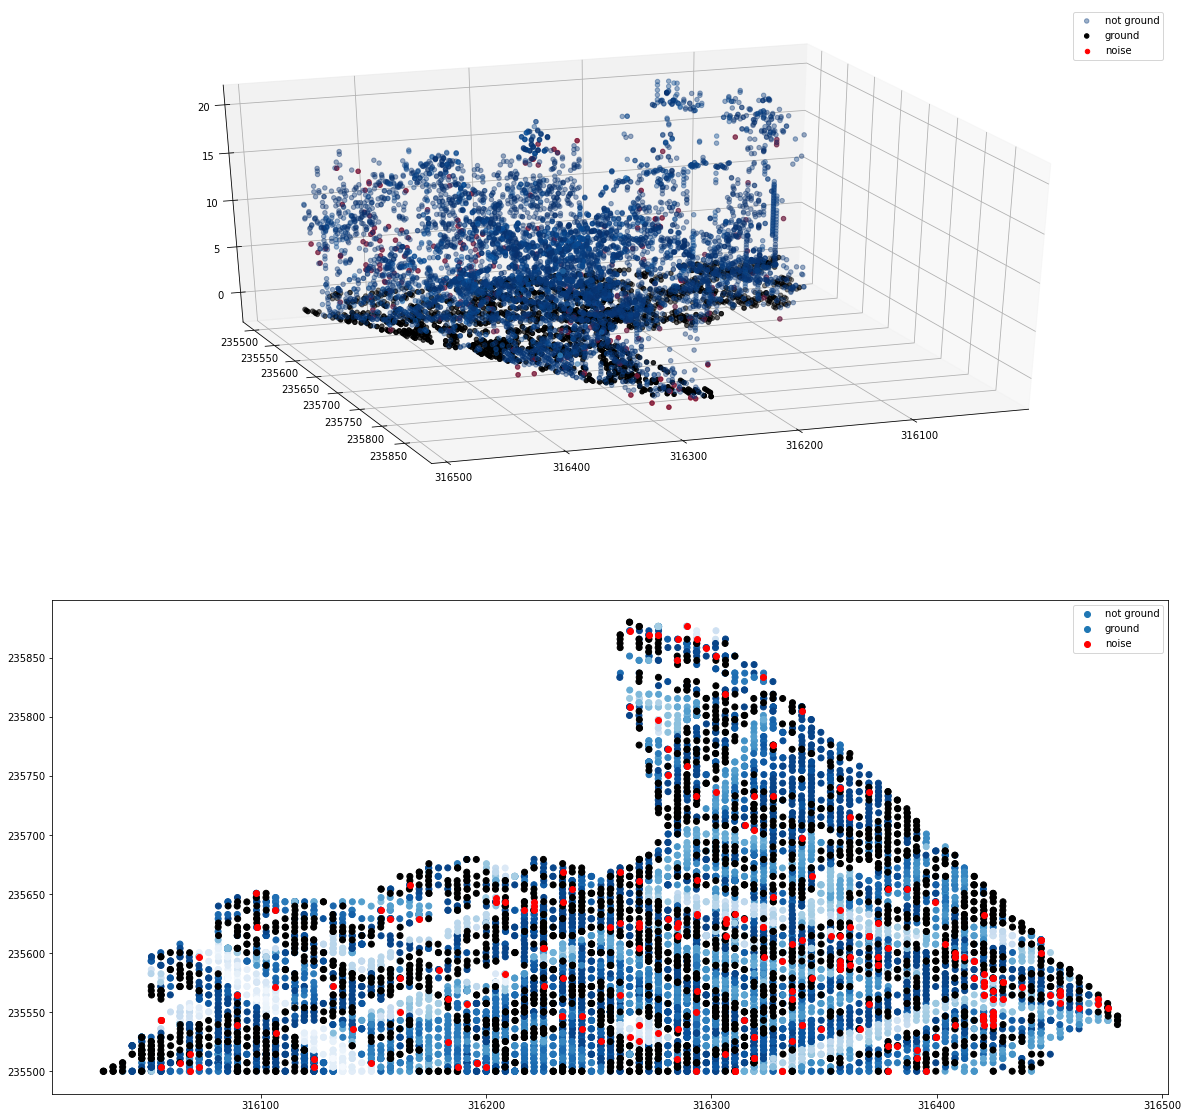

In [41]:
plotthethings(df3, df3.HeightAboveGround, 10000)

In [42]:
print("max height above ground: {} m".format(df3.HeightAboveGround.where(df3.Classification != 7).max()))
print("max height: {} m".format(df.Z.where(df3.Classification != 7).max()))

max height above ground: 44.30962977430691 m
max height: 59.915 m


In [22]:
print("min height above ground: {} m".format(df3.HeightAboveGround.where(df3.Classification != 7).min()))
print("min height: {} m".format(df3.Z.where(df3.Classification != 7).min()))

min height above ground: -2.4499999999999993 m
min height: 3.722 m


In [23]:
print("min ground: {} m".format(df3.HeightAboveGround.where(df3.Classification == 2).min()))
print("max ground: {} m".format(df3.HeightAboveGround.where(df3.Classification == 2 ).max()))

min ground: 0.0 m
max ground: 0.0 m


### About the morton order filter

Have you noticed that we've increased the number of points each time we've drawn a plot, but the area covered stays the same?

That's the reverse morton filter at work - it aims to distribute points across X and Y dimensions to represent the region as best as possible. Morton ordering (or space-filling curves) usually try to pack things together in space as best as possible. Let's see how that works out below - it's a pretty different picture!

For LiDAR points, usually points are stored in collection order (along time).

In [24]:
pipelineJson4 = [ workingfile,
    {
        "type":"filters.assign",
        "assignment":"Classification[:]=0"
    },
    {
        "type":"filters.elm",
        "cell":20.0,
        "class":7
    },
    {
        "type":"filters.pmf",
        "ignore":"Classification[7:7]"
    },
    {
        "type":"filters.outlier"
    },
    {
        "type":"filters.hag_delaunay"
    },
    {   "type":"filters.mortonorder",
        "reverse": False
    }
  ]

In [25]:
%%time

df4 = pdal2df(pipelineJson4, workingfile)

CPU times: user 1min 16s, sys: 1.26 s, total: 1min 17s
Wall time: 1min 17s


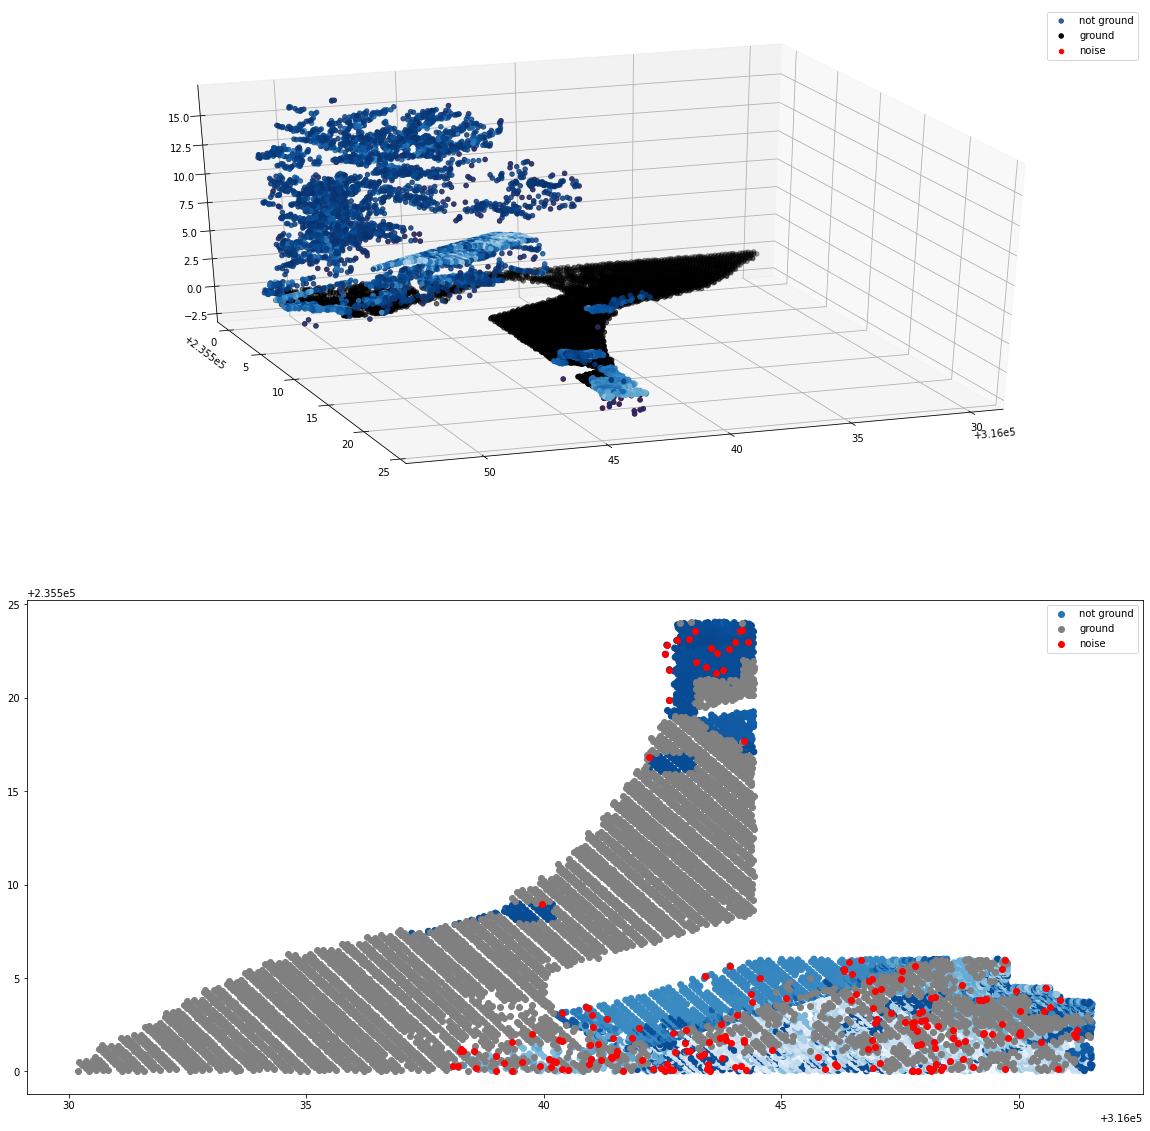

In [26]:
plotthethings(df4, df4.HeightAboveGround, 10000)

### No morton filter

In [27]:
pipelineJson5 = [ workingfile,
    {
        "type":"filters.assign",
        "assignment":"Classification[:]=0"
    },
    {
        "type":"filters.elm",
        "cell":20.0,
        "class":7
    },
    {
        "type":"filters.pmf",
        "ignore":"Classification[7:7]"
    },
    {
        "type":"filters.outlier"
    },
    {
        "type":"filters.hag"
    }
  ]

In [28]:
%%time

df5 = pdal2df(pipelineJson5, workingfile)

CPU times: user 55.3 s, sys: 908 ms, total: 56.2 s
Wall time: 56.4 s


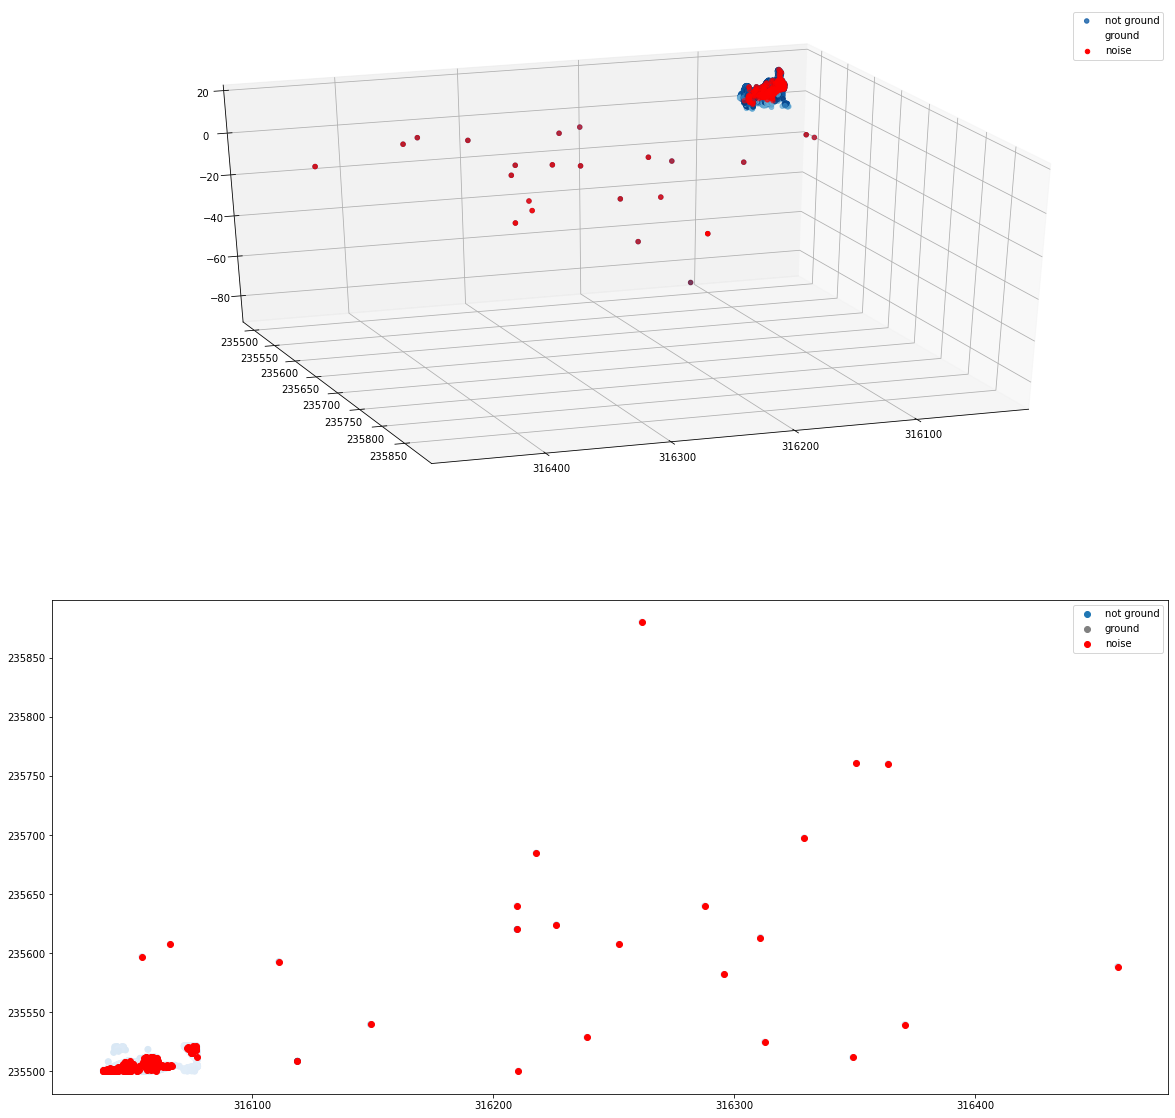

In [29]:
plotthethings(df5, df5.HeightAboveGround, 10000)

## Wrap up


This notebook steps through ways to drive PDAL using Python. We've seen how to:
- write pipelines in Python using Python variables
- drive pipelines using Python
- ingest results into numpy structured arrays
- convert arrays to Pandas dataframes
- visualise point data
- plot summary statistics

Since we're now tinkering with Scipy and Numpy, our possibilities for data analysis are almost limitless! The key thing to remember is that we're dealing with (mostly) disorganised, memory intensive data - it might pay to work on which parts of processes can be chunked up for a 'divide and conquer' approach.
